# Reconocedor de emociones

Para el siguiente trabajo se utilizó un dataset de imágenes digitalizadas de personas, para cada una de las cuales se identificó el rostro y se estimó la ubicación de 68 coordenadas (x, y) que mapean los puntos faciales. Estos landmarks fueron luego utilizados como entradas para entrenar una red neuronal con el propósito de poder predecir qué emoción representa cada rostro detectado.

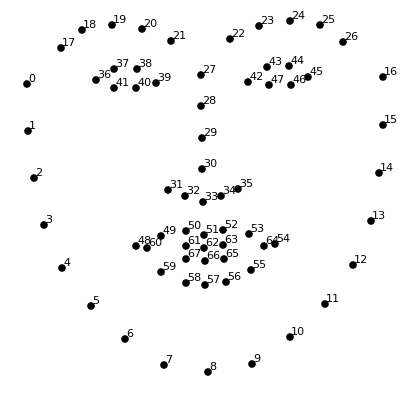

Dataset utilizado: https://www.kaggle.com/shawon10/ckplus

## Preparación del entorno y los datos

Se importa *numpy* para el manejo de los datos, *glob* para generar una lista de archivos que coinciden con un patron dado, *cv2* para la lectura de imágenes, *random* para aleatoriamente mezclar la lista de archivos y *phantom*, una librería de procesamiento forense de imágenes, que dispone de funciones para detectar rostros, extraer los 68 landmarks y normalizar los datos. También se importa tanto las capas como el modelo de keras para la definición del modelo.

In [1]:
import numpy as np
import glob
import cv2
import random
import phantom.faces as phf
import phantom.utils as phu
from keras import layers
from keras import models

Using TensorFlow backend.


Las emociones usadas quedan especificadas en la lista *emotions*, está lista nos permite seleccionar con qué emociones del dataset queremos trabajar y además etiquetar las imágenes extraidas. En cuanto a *num_emotions*, es una constante que especifica el número de emociones con las que estamos trabajando. Por otro lado, *data* nos servirá para ir almacenando los landmarks extraídos de los rostros.

In [2]:
emotions = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise'] #Lista con las emociones
num_emotions = 8 #variable global que contiene la cantidad de emociones en la lista 
data = [] #variable global donde de almacenan los datos

La función *get_files* genera una lista de archivos asociados a una determinada emocion y toma el 80% de esos archivos que para entrenar y el 20% restante para predecir.

In [3]:
def get_files(emotion):
    
    files = glob.glob(f".\\{emotion}\\*")
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #toma el %80 del principio del archivo para training
    prediction = files[-int(len(files)*0.2):] #toma el 20% del final del archivo para predicciones
    
    return training, prediction

La función *get_landmarks* detecta el rostro en una determinada imagen, luego estima la ubicación de 68 landmarks y finalmente devuelve estos landamarks, los datos que alimentan la red neuronal, normalizados.

In [26]:
def get_landmarks(image):
    data = []
    locations = phf.detect(image) #Devuelve una lista de tuplas (left,top,right,bottom) con la ubicacion de cada cara hallada en la imagen
    
    if not locations:
        return None #Si no detecta caras devuelvo la lista vacia
    
    list_landmarks =  phf.landmark(image, locations=locations) #Devuelve lista de objetos 'phantom.faces.Shape', cada uno de los cuales describe la posición y puntos de referencia de cada rostro
    data = phf.normalize_landmark(list_landmarks[0]) #normaliza --> rango [-1,1]
    
    flat = []
    for (x, y) in data:
        flat.extend((x, y))#adds the specified list elements to the end of the current list
    flat = np.array(flat) #convierte lista en numpy array
    
    return flat

La función *make_sets* devuelve listas con los datos (landmarks) y etiquetas tanto para el entrenamiento como para la predicción.

In [10]:
def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    

    for emotion in emotions:
        print(f" working on {emotion}")
        training, prediction = get_files(emotion)

        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            data = get_landmarks(image)
            if data is None:
                print("no face detected on this one")
            else:
                training_data.append(data) #append image array to training data list
                training_labels.append(emotions.index(emotion))
                
        for item in prediction:
            image = cv2.imread(item) #open image
            data = get_landmarks(image)
            if data is None:
                print("no face detected on this one")
            else:
                prediction_data.append(data) #append image array to prediction data list
                prediction_labels.append(emotions.index(emotion))
                
    return training_data, training_labels, prediction_data, prediction_labels

In [7]:
training_data, training_labels, prediction_data, prediction_labels = make_sets()

 working on anger
 working on contempt
 working on disgust
 working on fear
 working on happiness
no face detected on this one
 working on neutral
 working on sadness
 working on surprise


La función _keras.utils.to_categorical_ permite codificar las etiquetas, generando un vector de 8 elementos donde todos tienen valor cero excepto la categoría a la cual pertenece la emoción. Es necesaria esta codificación para que la red pueda trabajar de manera adecuada.

In [8]:
from keras.utils import to_categorical

training_labels = to_categorical(training_labels)
prediction_labels = to_categorical(prediction_labels)

## Definición del modelo 1

Se crea un modelo secuencial con capas densas para procesar los landmarks obtenidos.

In [11]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(136,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(num_emotions, activation='softmax')) 
#usar 'softmax' significa que la red generará una distribución de probabilidad sobre las emociones: 
#para cada muestra de entrada, la red producirá un vector de salida num_emotions dimensional,
#donde la salida [i] es la probabilidad de que la muestra pertenece a la emocion i.

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                2192      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
Total params: 2,600
Trainable params: 2,600
Non-trainable params: 0
_________________________________________________________________
None


### Configurando el modelo para enternarlo

In [30]:
model.compile(loss='categorical_crossentropy',#the quantity to minimize during training, 'categorical_crossentropy' measures the distance between two probability distributions
              optimizer='rmsprop', #specifies the exact way in which the gradient of the loss will to update parameters
              metrics=['accuracy'])

In [15]:
history = model.fit(np.array(training_data),
                    np.array(training_labels),
                    epochs=150,
                    batch_size=512,
                    validation_data=(np.array(prediction_data), np.array(prediction_labels)))

Train on 1066 samples, validate on 264 samples
Epoch 1/150
1066/1066 [==============================] - 2s 2ms/step - loss: 2.0949 - accuracy: 0.1266 - val_loss: 2.0356 - val_accuracy: 0.1288
Epoch 2/150
1066/1066 [==============================] - 0s 29us/step - loss: 2.0309 - accuracy: 0.1735 - val_loss: 2.0143 - val_accuracy: 0.2235
Epoch 3/150
1066/1066 [==============================] - 0s 59us/step - loss: 2.0111 - accuracy: 0.2205 - val_loss: 1.9915 - val_accuracy: 0.2121
Epoch 4/150
1066/1066 [==============================] - 0s 44us/step - loss: 1.9899 - accuracy: 0.2298 - val_loss: 1.9905 - val_accuracy: 0.2273
Epoch 5/150
1066/1066 [==============================] - 0s 29us/step - loss: 1.9823 - accuracy: 0.2261 - val_loss: 1.9670 - val_accuracy: 0.3182
Epoch 6/150
1066/1066 [==============================] - 0s 29us/step - loss: 1.9654 - accuracy: 0.2974 - val_loss: 1.9448 - val_accuracy: 0.3295
Epoch 7/150
1066/1066 [==============================] - 0s 29us/step - loss: 

Epoch 56/150
1066/1066 [==============================] - 0s 29us/step - loss: 1.5978 - accuracy: 0.4822 - val_loss: 1.6405 - val_accuracy: 0.4735
Epoch 57/150
1066/1066 [==============================] - 0s 44us/step - loss: 1.6104 - accuracy: 0.4690 - val_loss: 1.6049 - val_accuracy: 0.5114
Epoch 58/150
1066/1066 [==============================] - 0s 29us/step - loss: 1.5936 - accuracy: 0.4916 - val_loss: 1.5809 - val_accuracy: 0.5038
Epoch 59/150
1066/1066 [==============================] - 0s 29us/step - loss: 1.5801 - accuracy: 0.4784 - val_loss: 1.5791 - val_accuracy: 0.4962
Epoch 60/150
1066/1066 [==============================] - 0s 29us/step - loss: 1.5760 - accuracy: 0.5084 - val_loss: 1.5753 - val_accuracy: 0.4659
Epoch 61/150
1066/1066 [==============================] - 0s 29us/step - loss: 1.5700 - accuracy: 0.4690 - val_loss: 1.5775 - val_accuracy: 0.4318
Epoch 62/150
1066/1066 [==============================] - 0s 44us/step - loss: 1.5697 - accuracy: 0.4644 - val_loss: 1

### Evaluación del modelo
Definimos una función que nos permita graficar los parámetros del entrenamiento.

In [4]:
import matplotlib.pyplot as plt

def draw_history(history):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)
    plt.figure(1, figsize=(16, 14))
    plt.clf()
    
    # gráfico loss
    plt.subplot(221)
    plt.plot(epochs, h["loss"], "mo", label="Error del entrenamiento")
    plt.plot(epochs, h["val_loss"], "m", label="Error de validación")
    plt.xlabel("Épocas")
    plt.ylabel("Error")
    plt.legend()
    
    # gráfico accuracy
    plt.subplot(222)
    plt.plot(epochs, h["accuracy"], "co", label="Precisión del entrenamiento")
    plt.plot(epochs, h["val_accuracy"], "c", label="Precisión de validación")
    plt.xlabel("Épocas")
    plt.ylabel("Precisión")
    plt.legend()

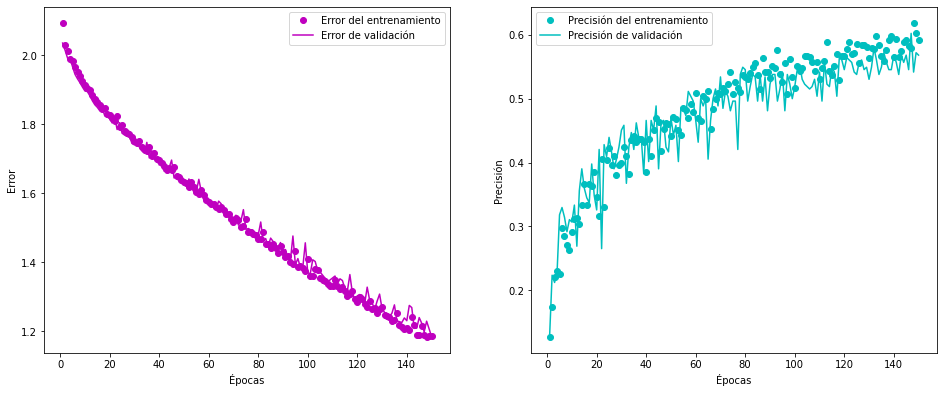

In [17]:
draw_history(history)

Definimos una funcion que nos permita visualizar la imagen y el procentaje asignado a cada una de las emociones dadas.

In [100]:
def predictEmotion(img_path,model_path):
    
    img = cv2.imread(img_path)
    model = models.load_model(model_path)
    
    land = get_landmarks(img)#obtengo los landmarks
    phu.imshow(phu.draw_faces(img, phf.landmark(img))) #imprimo la imagen
    results = model.predict(np.array([land]))
    
    i=0
    for result in np.nditer(results):
        print(f"{round(result*100)}% of {emotions[i]}")
        if i<(num_emotions - 1): #sino se pasa de rango
            i=i+1

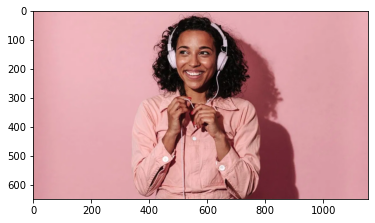

0.00040027170325629413 of anger
8.05518175184261e-06 of contempt
4.5048477659292985e-06 of disgust
0.003965075593441725 of fear
0.9955787062644958 of happiness
8.924261237552855e-06 of neutral
3.033917528227903e-05 of sadness
4.078964593645651e-06 of surprise


In [77]:
predictEmotion('test.jpg','model_1.h5')

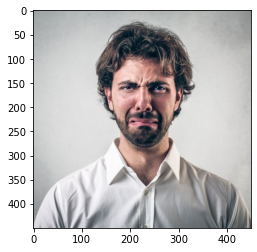

0.24641147255897522 of anger
0.005231861025094986 of contempt
0.5334333181381226 of disgust
0.017410380765795708 of fear
0.05914273113012314 of happiness
0.051120154559612274 of neutral
0.0868154838681221 of sadness
0.00043458075379021466 of surprise


In [78]:
predictEmotion('test2.jpg','model_1.h5')

Como vemos tenemos casi un 60% precisión y todo parece indicar que detecta bien las emociones representadas en las imagenes para testeo. Sin embargo, podemos mejorar todavía más el porcentaje de precisión aumentando la cantidad de datos con los que alimentamos la red.

Sin embargo, no necesitamos conseguir más datos, simplemente podemos mejorar el rendimiento del modelo aumentando los datos que ya tenemos. La idea es aplicar diversas transformaciones sobre las entradas originales, obteniendo muestras ligeramente diferentes pero iguales en esencia, lo que permite a la red desenvolverse mejor en la fase de inferencia.

## Utilizando augmentation 

In [46]:
augmentations = []

La función *aug_flip* recibe una lista de imagenes, y las espeja horizontalmente, así que aumenta por dos la cantidad de imágenes.

In [42]:
def aug_flip(it):
    for img in it:
        yield img
        yield img[:, ::-1]

La función *aug_rotate* elije un punto al azar adentro de la imagen y la rota +/-10° al azar. Todo lo que recibe aumenta por cinco.

In [43]:
def aug_rotate(it, times=5):
    for img in it:
        h, w = img.shape[:2]
        for t in range(times):
            x, y = random.uniform(0, w), random.uniform(0, h)
            angle = random.uniform(-10, 10)
            mat = cv2.getRotationMatrix2D((x, y), angle, 1.0)
            ret = cv2.warpAffine(img, mat, (w, h))
            yield ret

In [44]:
def make_augmented_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    

    for emotion in emotions:
        print(f" working on {emotion}")
        training, prediction = get_files(emotion)

        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            img = cv2.imread(item) #open image
            augmentations = aug_flip(aug_rotate([img]))
            for image in augmentations:
                data = get_landmarks(image)
                if data is None:
                    print(f"no face detected on this one: {item}")
                else:
                    training_data.append(data) #append image array to training data list
                    training_labels.append(emotions.index(emotion))
                
        for item in prediction:
            image = cv2.imread(item) #open image
            data = get_landmarks(image)
            if data is None:
                print("no face detected on this one")
            else:
                prediction_data.append(data) #append image array to prediction data list
                prediction_labels.append(emotions.index(emotion))
                
    return training_data, training_labels, prediction_data, prediction_labels

In [47]:
training_data, training_labels, prediction_data, prediction_labels = make_augmented_sets()

 working on anger
no face detected on this one: .\anger\S504_001_00000020.png
no face detected on this one: .\anger\S504_001_00000020.png
no face detected on this one: .\anger\S504_001_00000020.png
no face detected on this one: .\anger\S011_004_00000020.png
no face detected on this one: .\anger\S011_004_00000020.png
no face detected on this one: .\anger\S042_004_00000019.png
no face detected on this one: .\anger\S042_004_00000019.png
no face detected on this one: .\anger\S011_004_00000019.png
no face detected on this one: .\anger\S011_004_00000019.png
no face detected on this one: .\anger\anger (34).jpg
no face detected on this one: .\anger\S504_001_00000022.png
no face detected on this one: .\anger\S504_001_00000022.png
no face detected on this one: .\anger\S504_001_00000022.png
no face detected on this one: .\anger\S504_001_00000021.png
no face detected on this one: .\anger\S042_004_00000020.png
no face detected on this one: .\anger\S042_004_00000020.png
no face detected on this one:

In [48]:
training_labels = to_categorical(training_labels)
prediction_labels = to_categorical(prediction_labels)

#### Persistimos los datos
Para simplificarnos un poco el trabajo más adelante, almacenamos los datos de landmarks y labels obtenidos con la funcion *make_augmented_sets* en el archivo *'data_augmentation.npz'*.

In [65]:
np.savez('data_augmentation.npz', training_data = training_data, training_labels = training_labels, 
         prediction_data = prediction_data, prediction_labels = prediction_labels) 

De esta manera, se pueden extraer los datos del mismo archivo sin tener que volver a hacer todo el procesamiento. Para ello usamos la función *load('file.npz')* disponible en la librería numpy.

In [19]:
data_augmentation = np.load('data_augmentation.npz')
training_data = data_augmentation[training_data]
training_labels = data_augmentation[training_labels] 
prediction_data = data_augmentation[prediction_data]
prediction_labels = data_augmentation[prediction_labels]

### Modelo 1
Volvemos a insistir con le modelo que habíamos planteado anteriormente, pero ahora lo entrenamos con una mayor cantidad de datos gracias al uso de data augmentation.

In [22]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(136,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(num_emotions, activation='softmax')) 

In [23]:
model.compile(loss='categorical_crossentropy',#the quantity to minimize during training, 'categorical_crossentropy' measures the distance between two probability distributions
              optimizer='rmsprop', #specifies the exact way in which the gradient of the loss will to update parameters
              metrics=['accuracy'])

In [24]:
history = model.fit(np.array(training_data),
                    np.array(training_labels),
                    epochs=150,
                    batch_size=512,
                    validation_data=(np.array(prediction_data), np.array(prediction_labels)))

Train on 10563 samples, validate on 263 samples
Epoch 1/150
10563/10563 [==============================] - 3s 275us/step - loss: 1.9597 - accuracy: 0.2252 - val_loss: 1.8987 - val_accuracy: 0.3726
Epoch 2/150
10563/10563 [==============================] - 0s 6us/step - loss: 1.8876 - accuracy: 0.3246 - val_loss: 1.8566 - val_accuracy: 0.4144
Epoch 3/150
10563/10563 [==============================] - 0s 7us/step - loss: 1.8412 - accuracy: 0.3643 - val_loss: 1.7999 - val_accuracy: 0.4030
Epoch 4/150
10563/10563 [==============================] - 0s 7us/step - loss: 1.7851 - accuracy: 0.3862 - val_loss: 1.7427 - val_accuracy: 0.4106
Epoch 5/150
10563/10563 [==============================] - 0s 9us/step - loss: 1.7293 - accuracy: 0.4025 - val_loss: 1.6874 - val_accuracy: 0.4487
Epoch 6/150
10563/10563 [==============================] - 0s 9us/step - loss: 1.6736 - accuracy: 0.4263 - val_loss: 1.6185 - val_accuracy: 0.4715
Epoch 7/150
10563/10563 [==============================] - 0s 10us/s

Epoch 56/150
10563/10563 [==============================] - 0s 6us/step - loss: 0.8591 - accuracy: 0.7043 - val_loss: 0.8291 - val_accuracy: 0.7110
Epoch 57/150
10563/10563 [==============================] - 0s 7us/step - loss: 0.8546 - accuracy: 0.7030 - val_loss: 0.7897 - val_accuracy: 0.7148
Epoch 58/150
10563/10563 [==============================] - 0s 4us/step - loss: 0.8535 - accuracy: 0.7019 - val_loss: 0.7914 - val_accuracy: 0.7072
Epoch 59/150
10563/10563 [==============================] - 0s 6us/step - loss: 0.8410 - accuracy: 0.7087 - val_loss: 0.8046 - val_accuracy: 0.7072
Epoch 60/150
10563/10563 [==============================] - 0s 6us/step - loss: 0.8392 - accuracy: 0.7073 - val_loss: 0.7745 - val_accuracy: 0.7262
Epoch 61/150
10563/10563 [==============================] - 0s 4us/step - loss: 0.8367 - accuracy: 0.7095 - val_loss: 0.7875 - val_accuracy: 0.7148
Epoch 62/150
10563/10563 [==============================] - 0s 4us/step - loss: 0.8296 - accuracy: 0.7094 - val_

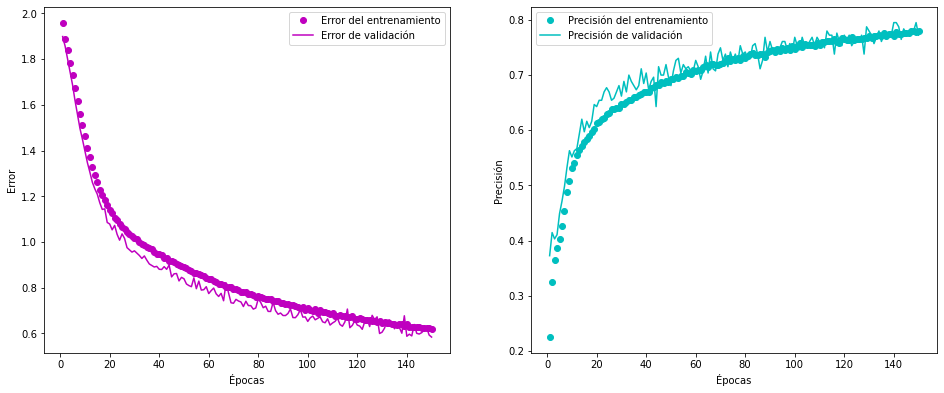

In [25]:
draw_history(history)

In [82]:
model.save('model_1_augmented.h5')

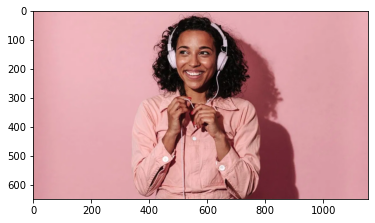

0.00022383261239156127 of anger
0.0002741866046562791 of contempt
0.0008583138696849346 of disgust
0.0025424561463296413 of fear
0.9958472847938538 of happiness
0.00017894658958539367 of neutral
3.13250238832552e-05 of sadness
4.371003160485998e-05 of surprise


In [84]:
predictEmotion('test.jpg', 'model_1_augmented.h5')

Aumentado la cantidad de datos con los que alimentamos nuestra red vemos como el porcentaje de precisión se acerca ahora al 80%, lo cual es un resultado muy positivo. De todas maneras, podemos seguir probando con distintas arquitecturas para llegar a un porcentaje mayor.

## Modelo 2

In [26]:
model_2 = models.Sequential()
model_2.add(layers.Dense(128, activation='relu', input_shape=(136,)))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(7, activation='relu'))
model_2.add(layers.Dense(num_emotions, activation='softmax')) 

In [27]:
model_2.compile(loss='categorical_crossentropy',#the quantity to minimize during training, 'categorical_crossentropy' measures the distance between two probability distributions
              optimizer='rmsprop', #specifies the exact way in which the gradient of the loss will to update parameters
              metrics=['accuracy'])

In [28]:
history_2 = model_2.fit(np.array(training_data),
                      np.array(training_labels),
                      epochs=150,
                      batch_size=512,
                      validation_data=(np.array(prediction_data), np.array(prediction_labels)))

Train on 10563 samples, validate on 263 samples
Epoch 1/150
10563/10563 [==============================] - 0s 38us/step - loss: 2.0334 - accuracy: 0.2351 - val_loss: 1.9675 - val_accuracy: 0.2357
Epoch 2/150
10563/10563 [==============================] - 0s 10us/step - loss: 1.9432 - accuracy: 0.2939 - val_loss: 1.9257 - val_accuracy: 0.4030
Epoch 3/150
10563/10563 [==============================] - 0s 15us/step - loss: 1.8757 - accuracy: 0.3365 - val_loss: 1.8384 - val_accuracy: 0.4030
Epoch 4/150
10563/10563 [==============================] - 0s 10us/step - loss: 1.8234 - accuracy: 0.3619 - val_loss: 1.7526 - val_accuracy: 0.3954
Epoch 5/150
10563/10563 [==============================] - 0s 10us/step - loss: 1.7853 - accuracy: 0.3739 - val_loss: 1.7291 - val_accuracy: 0.4144
Epoch 6/150
10563/10563 [==============================] - 0s 12us/step - loss: 1.7530 - accuracy: 0.3867 - val_loss: 1.6863 - val_accuracy: 0.4221
Epoch 7/150
10563/10563 [==============================] - 0s 12

Epoch 56/150
10563/10563 [==============================] - 0s 9us/step - loss: 1.1236 - accuracy: 0.6324 - val_loss: 1.1674 - val_accuracy: 0.6160
Epoch 57/150
10563/10563 [==============================] - 0s 10us/step - loss: 1.0971 - accuracy: 0.6393 - val_loss: 1.1575 - val_accuracy: 0.6274
Epoch 58/150
10563/10563 [==============================] - 0s 9us/step - loss: 1.1209 - accuracy: 0.6281 - val_loss: 1.0353 - val_accuracy: 0.6882
Epoch 59/150
10563/10563 [==============================] - 0s 10us/step - loss: 1.0773 - accuracy: 0.6448 - val_loss: 1.1910 - val_accuracy: 0.6350
Epoch 60/150
10563/10563 [==============================] - 0s 10us/step - loss: 1.0910 - accuracy: 0.6467 - val_loss: 1.0336 - val_accuracy: 0.6730
Epoch 61/150
10563/10563 [==============================] - 0s 10us/step - loss: 1.0649 - accuracy: 0.6503 - val_loss: 1.0913 - val_accuracy: 0.6540
Epoch 62/150
10563/10563 [==============================] - 0s 9us/step - loss: 1.0607 - accuracy: 0.6535 - 

In [30]:
model_2.save('model_2_augmented.h5')

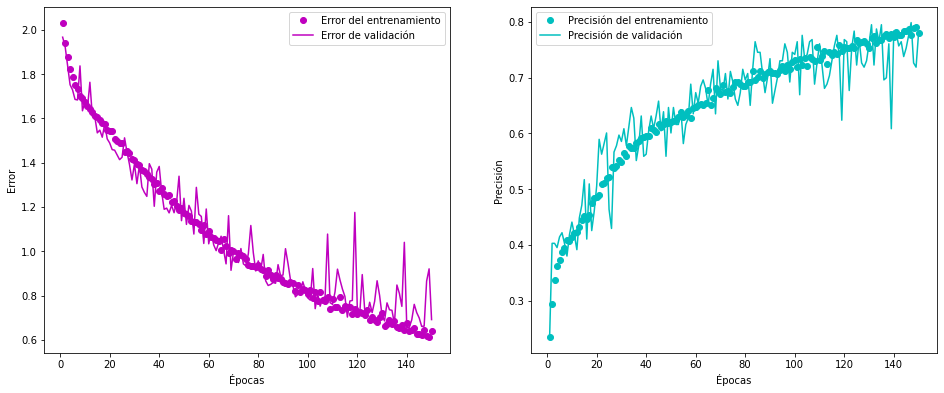

In [29]:
draw_history(history_2)

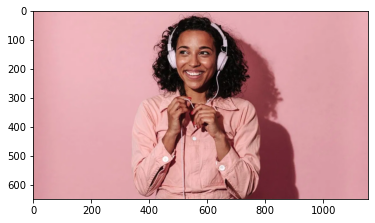

0.022033918648958206 of anger
0.02129693701863289 of contempt
0.040361110121011734 of disgust
0.02637466974556446 of fear
0.8548873662948608 of happiness
0.010335074737668037 of neutral
0.014901481568813324 of sadness
0.009809513576328754 of surprise


In [31]:
predictEmotion('test.jpg','model_2_augmented.h5')

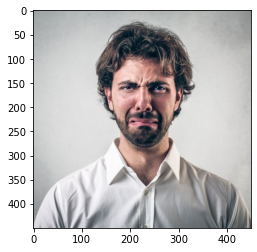

0.19876611232757568 of anger
0.0013000289909541607 of contempt
0.32797786593437195 of disgust
0.04540187492966652 of fear
0.3979617953300476 of happiness
0.006314821541309357 of neutral
0.00972916278988123 of sadness
0.012548331171274185 of surprise


In [35]:
img = cv2.imread("test2.jpg")
predictEmotion(img)

Se observa que el aumento significativo de capas en la red no genera precisamente una mejora en la precisión.

## Modelo 3

In [73]:
model_3 = models.Sequential()
model_3.add(layers.Dense(32, activation="relu", input_shape=(136,)))
model_3.add(layers.Dense(16, activation="relu"))
model_3.add(layers.Dense(num_emotions, activation="softmax"))

In [74]:
model_3.compile(loss='categorical_crossentropy',#the quantity to minimize during training, 'categorical_crossentropy' measures the distance between two probability distributions
              optimizer='rmsprop', #specifies the exact way in which the gradient of the loss will to update parameters
              metrics=['accuracy'])

In [75]:
history_3 = model_3.fit(np.array(training_data),
                      np.array(training_labels),
                      epochs=1000,
                      batch_size=512,
                      validation_data=(np.array(prediction_data), np.array(prediction_labels)))

Train on 10563 samples, validate on 263 samples
Epoch 1/1000
10563/10563 [==============================] - 0s 18us/step - loss: 1.9511 - accuracy: 0.2314 - val_loss: 1.9027 - val_accuracy: 0.3422
Epoch 2/1000
10563/10563 [==============================] - 0s 7us/step - loss: 1.8796 - accuracy: 0.2871 - val_loss: 1.8434 - val_accuracy: 0.3156
Epoch 3/1000
10563/10563 [==============================] - 0s 7us/step - loss: 1.8219 - accuracy: 0.3713 - val_loss: 1.7846 - val_accuracy: 0.5057
Epoch 4/1000
10563/10563 [==============================] - 0s 10us/step - loss: 1.7585 - accuracy: 0.4552 - val_loss: 1.7346 - val_accuracy: 0.4601
Epoch 5/1000
10563/10563 [==============================] - 0s 10us/step - loss: 1.6961 - accuracy: 0.4867 - val_loss: 1.6376 - val_accuracy: 0.5057
Epoch 6/1000
10563/10563 [==============================] - 0s 10us/step - loss: 1.6372 - accuracy: 0.4970 - val_loss: 1.5765 - val_accuracy: 0.5285
Epoch 7/1000
10563/10563 [==============================] - 

Epoch 56/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.8465 - accuracy: 0.7013 - val_loss: 0.7942 - val_accuracy: 0.7034
Epoch 57/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.8342 - accuracy: 0.7049 - val_loss: 0.7953 - val_accuracy: 0.7148
Epoch 58/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.8370 - accuracy: 0.7060 - val_loss: 0.8115 - val_accuracy: 0.7262
Epoch 59/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.8271 - accuracy: 0.7156 - val_loss: 0.7813 - val_accuracy: 0.7110
Epoch 60/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.8241 - accuracy: 0.7137 - val_loss: 0.8015 - val_accuracy: 0.6996
Epoch 61/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.8183 - accuracy: 0.7128 - val_loss: 0.8006 - val_accuracy: 0.7224
Epoch 62/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.8183 - accuracy: 0.7133

Epoch 111/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.6634 - accuracy: 0.7653 - val_loss: 0.6409 - val_accuracy: 0.7795
Epoch 112/1000
10563/10563 [==============================] - 0s 10us/step - loss: 0.6657 - accuracy: 0.7645 - val_loss: 0.6390 - val_accuracy: 0.7681
Epoch 113/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.6610 - accuracy: 0.7613 - val_loss: 0.6197 - val_accuracy: 0.7833
Epoch 114/1000
10563/10563 [==============================] - 0s 9us/step - loss: 0.6626 - accuracy: 0.7594 - val_loss: 0.6245 - val_accuracy: 0.7833
Epoch 115/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.6518 - accuracy: 0.7689 - val_loss: 0.6334 - val_accuracy: 0.7795
Epoch 116/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.6589 - accuracy: 0.7600 - val_loss: 0.6388 - val_accuracy: 0.7681
Epoch 117/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.6535 - accuracy

Epoch 220/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.5317 - accuracy: 0.8144 - val_loss: 0.5597 - val_accuracy: 0.7795
Epoch 221/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.5404 - accuracy: 0.8078 - val_loss: 0.5260 - val_accuracy: 0.8213
Epoch 222/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.5404 - accuracy: 0.8097 - val_loss: 0.5483 - val_accuracy: 0.8251
Epoch 223/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.5327 - accuracy: 0.8151 - val_loss: 0.5607 - val_accuracy: 0.8023
Epoch 224/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.5404 - accuracy: 0.8090 - val_loss: 0.5087 - val_accuracy: 0.8365
Epoch 225/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.5297 - accuracy: 0.8137 - val_loss: 0.4968 - val_accuracy: 0.8441
Epoch 226/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.5308 - accuracy:

Epoch 329/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.4802 - accuracy: 0.8315 - val_loss: 0.5038 - val_accuracy: 0.8289
Epoch 330/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.4711 - accuracy: 0.8321 - val_loss: 0.5042 - val_accuracy: 0.8251
Epoch 331/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.4755 - accuracy: 0.8353 - val_loss: 0.5509 - val_accuracy: 0.8137
Epoch 332/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.4745 - accuracy: 0.8370 - val_loss: 0.5286 - val_accuracy: 0.8061
Epoch 333/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.4805 - accuracy: 0.8258 - val_loss: 0.5362 - val_accuracy: 0.8099
Epoch 334/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.4761 - accuracy: 0.8340 - val_loss: 0.5688 - val_accuracy: 0.8137
Epoch 335/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.4654 - accuracy:

Epoch 438/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.4292 - accuracy: 0.8513 - val_loss: 0.4372 - val_accuracy: 0.8631
Epoch 439/1000
10563/10563 [==============================] - 0s 9us/step - loss: 0.4307 - accuracy: 0.8473 - val_loss: 0.5048 - val_accuracy: 0.8289
Epoch 440/1000
10563/10563 [==============================] - 0s 9us/step - loss: 0.4339 - accuracy: 0.8462 - val_loss: 0.4677 - val_accuracy: 0.8365
Epoch 441/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.4256 - accuracy: 0.8529 - val_loss: 0.4451 - val_accuracy: 0.8555
Epoch 442/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.4253 - accuracy: 0.8526 - val_loss: 0.5424 - val_accuracy: 0.8289
Epoch 443/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.4403 - accuracy: 0.8443 - val_loss: 0.4686 - val_accuracy: 0.8517
Epoch 444/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.4196 - accuracy:

Epoch 547/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3985 - accuracy: 0.8596 - val_loss: 0.5514 - val_accuracy: 0.8137
Epoch 548/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3956 - accuracy: 0.8623 - val_loss: 0.4563 - val_accuracy: 0.8441
Epoch 549/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.4060 - accuracy: 0.8563 - val_loss: 0.4671 - val_accuracy: 0.8327
Epoch 550/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.4022 - accuracy: 0.8570 - val_loss: 0.4752 - val_accuracy: 0.8365
Epoch 551/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.4009 - accuracy: 0.8605 - val_loss: 0.4664 - val_accuracy: 0.8289
Epoch 552/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3904 - accuracy: 0.8607 - val_loss: 0.4442 - val_accuracy: 0.8479
Epoch 553/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.4037 - accuracy:

Epoch 656/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3768 - accuracy: 0.8684 - val_loss: 0.4630 - val_accuracy: 0.8517
Epoch 657/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.3802 - accuracy: 0.8675 - val_loss: 0.4788 - val_accuracy: 0.8479
Epoch 658/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3697 - accuracy: 0.8736 - val_loss: 0.4612 - val_accuracy: 0.8441
Epoch 659/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.3854 - accuracy: 0.8635 - val_loss: 0.4294 - val_accuracy: 0.8441
Epoch 660/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.3730 - accuracy: 0.8687 - val_loss: 0.4719 - val_accuracy: 0.8365
Epoch 661/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.3716 - accuracy: 0.8692 - val_loss: 0.4487 - val_accuracy: 0.8479
Epoch 662/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3794 - accuracy:

Epoch 765/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3498 - accuracy: 0.8794 - val_loss: 0.4240 - val_accuracy: 0.8517
Epoch 766/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.3645 - accuracy: 0.8744 - val_loss: 0.4298 - val_accuracy: 0.8517
Epoch 767/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3558 - accuracy: 0.8771 - val_loss: 0.4803 - val_accuracy: 0.8479
Epoch 768/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3573 - accuracy: 0.8740 - val_loss: 0.4457 - val_accuracy: 0.8593
Epoch 769/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.3520 - accuracy: 0.8762 - val_loss: 0.5302 - val_accuracy: 0.8137
Epoch 770/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3558 - accuracy: 0.8754 - val_loss: 0.4260 - val_accuracy: 0.8517
Epoch 771/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3404 - accuracy:

Epoch 874/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.3469 - accuracy: 0.8770 - val_loss: 0.4693 - val_accuracy: 0.8479
Epoch 875/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3324 - accuracy: 0.8812 - val_loss: 0.4463 - val_accuracy: 0.8289
Epoch 876/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3412 - accuracy: 0.8783 - val_loss: 0.4793 - val_accuracy: 0.8213
Epoch 877/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3385 - accuracy: 0.8793 - val_loss: 0.4642 - val_accuracy: 0.8479
Epoch 878/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3376 - accuracy: 0.8812 - val_loss: 0.4904 - val_accuracy: 0.8365
Epoch 879/1000
10563/10563 [==============================] - 0s 4us/step - loss: 0.3316 - accuracy: 0.8846 - val_loss: 0.4795 - val_accuracy: 0.8175
Epoch 880/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.3315 - accuracy:

Epoch 983/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3112 - accuracy: 0.8903 - val_loss: 0.4996 - val_accuracy: 0.8327
Epoch 984/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3280 - accuracy: 0.8817 - val_loss: 0.4208 - val_accuracy: 0.8403
Epoch 985/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.3288 - accuracy: 0.8805 - val_loss: 0.4337 - val_accuracy: 0.8479
Epoch 986/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3147 - accuracy: 0.8862 - val_loss: 0.4459 - val_accuracy: 0.8479
Epoch 987/1000
10563/10563 [==============================] - 0s 7us/step - loss: 0.3240 - accuracy: 0.8827 - val_loss: 0.4631 - val_accuracy: 0.8441
Epoch 988/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3104 - accuracy: 0.8892 - val_loss: 0.4712 - val_accuracy: 0.8441
Epoch 989/1000
10563/10563 [==============================] - 0s 6us/step - loss: 0.3264 - accuracy:

In [76]:
model_3.save('model_3_augmented.h5')

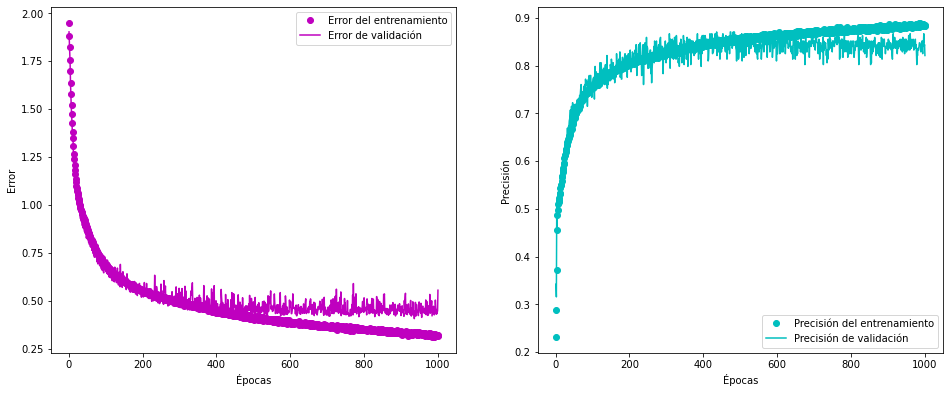

In [77]:
draw_history(history_3)

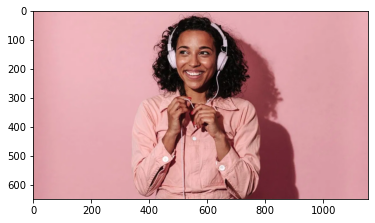

0.0006945921923033893 of anger
2.8765580100758718e-18 of contempt
3.708687472681049e-07 of disgust
0.012008553370833397 of fear
0.9832627773284912 of happiness
5.4839648377935646e-09 of neutral
0.004016812425106764 of sadness
1.6904074072954245e-05 of surprise


In [93]:
predictEmotion('test.jpg','model_3_augmented.h5')

## Modelo 4

In [66]:
model_4 = models.Sequential()
model_4.add(layers.Dense(64, activation="relu", input_shape=(136,)))
model_4.add(layers.Dense(64, activation="relu"))
model_4.add(layers.Dense(64, activation="relu"))
model_4.add(layers.Dense(8, activation="relu"))
model_4.add(layers.Dense(num_emotions, activation="softmax"))

In [67]:
model_4.compile(loss='categorical_crossentropy',#the quantity to minimize during training, 'categorical_crossentropy' measures the distance between two probability distributions
                optimizer='rmsprop', #specifies the exact way in which the gradient of the loss will to update parameters
                metrics=['accuracy'])

In [68]:
history_4 = model_4.fit(np.array(training_data),
                      np.array(training_labels),
                      epochs=200,
                      batch_size=512,
                      validation_data=(np.array(prediction_data), np.array(prediction_labels)))

Train on 10563 samples, validate on 263 samples
Epoch 1/200
10563/10563 [==============================] - 0s 24us/step - loss: 2.0050 - accuracy: 0.2253 - val_loss: 1.9451 - val_accuracy: 0.2890
Epoch 2/200
10563/10563 [==============================] - 0s 13us/step - loss: 1.9137 - accuracy: 0.2581 - val_loss: 1.8306 - val_accuracy: 0.2700
Epoch 3/200
10563/10563 [==============================] - 0s 12us/step - loss: 1.8283 - accuracy: 0.3410 - val_loss: 1.8252 - val_accuracy: 0.4563
Epoch 4/200
10563/10563 [==============================] - 0s 12us/step - loss: 1.7571 - accuracy: 0.3996 - val_loss: 1.6750 - val_accuracy: 0.4259
Epoch 5/200
10563/10563 [==============================] - 0s 12us/step - loss: 1.6897 - accuracy: 0.4202 - val_loss: 1.5974 - val_accuracy: 0.4411
Epoch 6/200
10563/10563 [==============================] - 0s 10us/step - loss: 1.6110 - accuracy: 0.4440 - val_loss: 1.5654 - val_accuracy: 0.4791
Epoch 7/200
10563/10563 [==============================] - 0s 12

Epoch 56/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.7838 - accuracy: 0.7109 - val_loss: 0.7549 - val_accuracy: 0.7262
Epoch 57/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.7936 - accuracy: 0.7128 - val_loss: 0.8137 - val_accuracy: 0.6882
Epoch 58/200
10563/10563 [==============================] - ETA: 0s - loss: 0.7639 - accuracy: 0.72 - 0s 7us/step - loss: 0.7727 - accuracy: 0.7200 - val_loss: 0.7176 - val_accuracy: 0.7262
Epoch 59/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.7541 - accuracy: 0.7259 - val_loss: 0.6957 - val_accuracy: 0.7605
Epoch 60/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.7775 - accuracy: 0.7186 - val_loss: 0.7492 - val_accuracy: 0.7300
Epoch 61/200
10563/10563 [==============================] - 0s 7us/step - loss: 0.7553 - accuracy: 0.7260 - val_loss: 0.7167 - val_accuracy: 0.7490
Epoch 62/200
10563/10563 [==============================] - 0s 7us/ste

Epoch 111/200
10563/10563 [==============================] - 0s 7us/step - loss: 0.5978 - accuracy: 0.7816 - val_loss: 0.5963 - val_accuracy: 0.8137
Epoch 112/200
10563/10563 [==============================] - 0s 7us/step - loss: 0.6060 - accuracy: 0.7787 - val_loss: 0.5940 - val_accuracy: 0.8099
Epoch 113/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.5821 - accuracy: 0.7859 - val_loss: 0.6070 - val_accuracy: 0.8023
Epoch 114/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.5970 - accuracy: 0.7814 - val_loss: 0.6651 - val_accuracy: 0.7643
Epoch 115/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.5975 - accuracy: 0.7872 - val_loss: 0.5783 - val_accuracy: 0.8099
Epoch 116/200
10563/10563 [==============================] - 0s 10us/step - loss: 0.5956 - accuracy: 0.7797 - val_loss: 0.7630 - val_accuracy: 0.7300
Epoch 117/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.5818 - accuracy: 0.788

Epoch 166/200
10563/10563 [==============================] - 0s 15us/step - loss: 0.4761 - accuracy: 0.8281 - val_loss: 0.6397 - val_accuracy: 0.7795
Epoch 167/200
10563/10563 [==============================] - 0s 10us/step - loss: 0.4941 - accuracy: 0.8161 - val_loss: 0.5803 - val_accuracy: 0.8099
Epoch 168/200
10563/10563 [==============================] - 0s 13us/step - loss: 0.4895 - accuracy: 0.8195 - val_loss: 0.6041 - val_accuracy: 0.8175
Epoch 169/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.5002 - accuracy: 0.8184 - val_loss: 0.6605 - val_accuracy: 0.7871
Epoch 170/200
10563/10563 [==============================] - 0s 10us/step - loss: 0.4932 - accuracy: 0.8197 - val_loss: 0.5615 - val_accuracy: 0.8365
Epoch 171/200
10563/10563 [==============================] - 0s 9us/step - loss: 0.4804 - accuracy: 0.8269 - val_loss: 0.5829 - val_accuracy: 0.8175
Epoch 172/200
10563/10563 [==============================] - 0s 12us/step - loss: 0.4927 - accuracy: 0

In [60]:
model_4.save('model_4_augmented.h5')

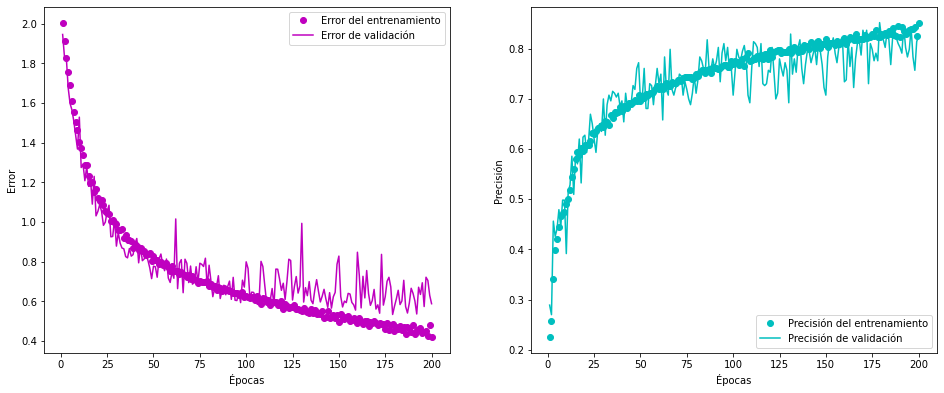

In [69]:
draw_history(history_4)

In [91]:
model_4 = models.Sequential()
model_4.add(layers.Dense(64, activation="elu", input_shape=(136,)))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(64, activation="elu"))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(64, activation="elu"))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(num_emotions, activation="softmax"))

In [92]:
model_4.compile(loss='categorical_crossentropy',#the quantity to minimize during training, 'categorical_crossentropy' measures the distance between two probability distributions
                optimizer='rmsprop', #specifies the exact way in which the gradient of the loss will to update parameters
                metrics=['accuracy'])

In [93]:
history_4 = model_4.fit(np.array(training_data),
                      np.array(training_labels),
                      epochs=1000,
                      batch_size=512,
                      validation_data=(np.array(prediction_data), np.array(prediction_labels)))

Train on 10563 samples, validate on 263 samples
Epoch 1/1000
10563/10563 [==============================] - 0s 39us/step - loss: 1.9526 - accuracy: 0.2513 - val_loss: 1.7855 - val_accuracy: 0.2852
Epoch 2/1000
10563/10563 [==============================] - 0s 19us/step - loss: 1.7141 - accuracy: 0.3975 - val_loss: 1.5092 - val_accuracy: 0.5209
Epoch 3/1000
10563/10563 [==============================] - 0s 19us/step - loss: 1.4953 - accuracy: 0.4853 - val_loss: 1.3846 - val_accuracy: 0.4487
Epoch 4/1000
10563/10563 [==============================] - 0s 17us/step - loss: 1.3538 - accuracy: 0.5133 - val_loss: 1.2727 - val_accuracy: 0.5665
Epoch 5/1000
10563/10563 [==============================] - 0s 17us/step - loss: 1.2423 - accuracy: 0.5522 - val_loss: 1.5130 - val_accuracy: 0.4335
Epoch 6/1000
10563/10563 [==============================] - 0s 19us/step - loss: 1.1962 - accuracy: 0.5698 - val_loss: 1.4344 - val_accuracy: 0.4677
Epoch 7/1000
10563/10563 [==============================] 

10563/10563 [==============================] - 0s 15us/step - loss: 0.6626 - accuracy: 0.7636 - val_loss: 0.6235 - val_accuracy: 0.7985
Epoch 110/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.6358 - accuracy: 0.7714 - val_loss: 0.5179 - val_accuracy: 0.8327
Epoch 111/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.6612 - accuracy: 0.7603 - val_loss: 0.5947 - val_accuracy: 0.7719
Epoch 112/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.6444 - accuracy: 0.7691 - val_loss: 0.5564 - val_accuracy: 0.8061
Epoch 113/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.6465 - accuracy: 0.7714 - val_loss: 0.5918 - val_accuracy: 0.7795
Epoch 114/1000
10563/10563 [==============================] - 0s 16us/step - loss: 0.6576 - accuracy: 0.7636 - val_loss: 0.6014 - val_accuracy: 0.7947
Epoch 115/1000
10563/10563 [==============================] - 0s 22us/step - loss: 0.6447 - accuracy: 0.7699 

10563/10563 [==============================] - 0s 13us/step - loss: 0.5884 - accuracy: 0.7875 - val_loss: 0.4985 - val_accuracy: 0.7985
Epoch 164/1000
10563/10563 [==============================] - 0s 16us/step - loss: 0.5975 - accuracy: 0.7846 - val_loss: 0.5006 - val_accuracy: 0.8061
Epoch 165/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.5822 - accuracy: 0.7916 - val_loss: 0.4534 - val_accuracy: 0.8365
Epoch 166/1000
10563/10563 [==============================] - 0s 16us/step - loss: 0.6038 - accuracy: 0.7835 - val_loss: 0.5514 - val_accuracy: 0.8099
Epoch 167/1000
10563/10563 [==============================] - 0s 16us/step - loss: 0.5850 - accuracy: 0.7909 - val_loss: 0.4911 - val_accuracy: 0.7985
Epoch 168/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.5950 - accuracy: 0.7840 - val_loss: 0.6223 - val_accuracy: 0.7719
Epoch 169/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.6062 - accuracy: 0.7838 

10563/10563 [==============================] - 0s 17us/step - loss: 0.4840 - accuracy: 0.8227 - val_loss: 0.3882 - val_accuracy: 0.8593
Epoch 272/1000
10563/10563 [==============================] - 0s 17us/step - loss: 0.5116 - accuracy: 0.8163 - val_loss: 0.4616 - val_accuracy: 0.8403
Epoch 273/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.4943 - accuracy: 0.8200 - val_loss: 0.3900 - val_accuracy: 0.8555
Epoch 274/1000
10563/10563 [==============================] - 0s 17us/step - loss: 0.4872 - accuracy: 0.8299 - val_loss: 0.4757 - val_accuracy: 0.8327
Epoch 275/1000
10563/10563 [==============================] - 0s 16us/step - loss: 0.5013 - accuracy: 0.8163 - val_loss: 0.4864 - val_accuracy: 0.8327
Epoch 276/1000
10563/10563 [==============================] - 0s 16us/step - loss: 0.5101 - accuracy: 0.8137 - val_loss: 0.4777 - val_accuracy: 0.8365
Epoch 277/1000
10563/10563 [==============================] - 0s 18us/step - loss: 0.5010 - accuracy: 0.8166 

10563/10563 [==============================] - 0s 14us/step - loss: 0.4324 - accuracy: 0.8402 - val_loss: 0.4134 - val_accuracy: 0.8707
Epoch 380/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.4411 - accuracy: 0.8405 - val_loss: 0.5548 - val_accuracy: 0.8023
Epoch 381/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.4479 - accuracy: 0.8377 - val_loss: 0.5830 - val_accuracy: 0.7795
Epoch 382/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.4482 - accuracy: 0.8348 - val_loss: 0.4674 - val_accuracy: 0.8517
Epoch 383/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.4573 - accuracy: 0.8315 - val_loss: 0.4020 - val_accuracy: 0.8555
Epoch 384/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.4336 - accuracy: 0.8404 - val_loss: 0.4039 - val_accuracy: 0.8631
Epoch 385/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.4337 - accuracy: 0.8397 

10563/10563 [==============================] - 0s 14us/step - loss: 0.4286 - accuracy: 0.8394 - val_loss: 0.4561 - val_accuracy: 0.8403
Epoch 434/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.4022 - accuracy: 0.8478 - val_loss: 0.4030 - val_accuracy: 0.8479
Epoch 435/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.4171 - accuracy: 0.8480 - val_loss: 0.4142 - val_accuracy: 0.8593
Epoch 436/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.4233 - accuracy: 0.8450 - val_loss: 0.4238 - val_accuracy: 0.8593
Epoch 437/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.4070 - accuracy: 0.8493 - val_loss: 0.3890 - val_accuracy: 0.8707
Epoch 438/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.4146 - accuracy: 0.8443 - val_loss: 0.5552 - val_accuracy: 0.8175
Epoch 439/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.4128 - accuracy: 0.8466 

10563/10563 [==============================] - 0s 16us/step - loss: 0.3719 - accuracy: 0.8585 - val_loss: 0.4668 - val_accuracy: 0.8403
Epoch 542/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.3728 - accuracy: 0.8589 - val_loss: 0.4652 - val_accuracy: 0.8479
Epoch 543/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.3928 - accuracy: 0.8529 - val_loss: 0.4067 - val_accuracy: 0.8745
Epoch 544/1000
10563/10563 [==============================] - 0s 15us/step - loss: 0.3766 - accuracy: 0.8597 - val_loss: 0.3950 - val_accuracy: 0.8555
Epoch 545/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.3651 - accuracy: 0.8626 - val_loss: 0.4257 - val_accuracy: 0.8517
Epoch 546/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.3952 - accuracy: 0.8513 - val_loss: 0.4355 - val_accuracy: 0.8403
Epoch 547/1000
10563/10563 [==============================] - 0s 17us/step - loss: 0.3824 - accuracy: 0.8572 

10563/10563 [==============================] - 0s 14us/step - loss: 0.3258 - accuracy: 0.8783 - val_loss: 0.4509 - val_accuracy: 0.8555
Epoch 650/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.3572 - accuracy: 0.8687 - val_loss: 0.4131 - val_accuracy: 0.8707
Epoch 651/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.3455 - accuracy: 0.8714 - val_loss: 0.4210 - val_accuracy: 0.8631
Epoch 652/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.3387 - accuracy: 0.8779 - val_loss: 0.4289 - val_accuracy: 0.8669
Epoch 653/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.3370 - accuracy: 0.8727 - val_loss: 0.4558 - val_accuracy: 0.8403
Epoch 654/1000
10563/10563 [==============================] - 0s 12us/step - loss: 0.3479 - accuracy: 0.8725 - val_loss: 0.4292 - val_accuracy: 0.8631
Epoch 655/1000
10563/10563 [==============================] - 0s 12us/step - loss: 0.3418 - accuracy: 0.8725 

10563/10563 [==============================] - 0s 13us/step - loss: 0.3061 - accuracy: 0.8843 - val_loss: 0.5635 - val_accuracy: 0.8365
Epoch 758/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.3203 - accuracy: 0.8799 - val_loss: 0.4289 - val_accuracy: 0.8745
Epoch 759/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.3199 - accuracy: 0.8835 - val_loss: 0.4290 - val_accuracy: 0.8441
Epoch 760/1000
10563/10563 [==============================] - 0s 12us/step - loss: 0.3197 - accuracy: 0.8838 - val_loss: 0.4181 - val_accuracy: 0.8707
Epoch 761/1000
10563/10563 [==============================] - 0s 12us/step - loss: 0.3122 - accuracy: 0.8853 - val_loss: 0.4784 - val_accuracy: 0.8555
Epoch 762/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.3076 - accuracy: 0.8863 - val_loss: 0.4631 - val_accuracy: 0.8707
Epoch 763/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.3087 - accuracy: 0.8867 

10563/10563 [==============================] - 0s 13us/step - loss: 0.2864 - accuracy: 0.8915 - val_loss: 0.4670 - val_accuracy: 0.8745
Epoch 866/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2810 - accuracy: 0.8936 - val_loss: 0.4126 - val_accuracy: 0.8821
Epoch 867/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2850 - accuracy: 0.8955 - val_loss: 0.4794 - val_accuracy: 0.8669
Epoch 868/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2873 - accuracy: 0.8951 - val_loss: 0.4469 - val_accuracy: 0.8631
Epoch 869/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.3131 - accuracy: 0.8864 - val_loss: 0.4040 - val_accuracy: 0.8783
Epoch 870/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2885 - accuracy: 0.8919 - val_loss: 0.4700 - val_accuracy: 0.8555
Epoch 871/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2698 - accuracy: 0.8964 

10563/10563 [==============================] - 0s 13us/step - loss: 0.2708 - accuracy: 0.9023 - val_loss: 0.4277 - val_accuracy: 0.8707
Epoch 974/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2640 - accuracy: 0.9041 - val_loss: 0.5087 - val_accuracy: 0.8631
Epoch 975/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2608 - accuracy: 0.9014 - val_loss: 0.4604 - val_accuracy: 0.8593
Epoch 976/1000
10563/10563 [==============================] - 0s 14us/step - loss: 0.2774 - accuracy: 0.8988 - val_loss: 0.4592 - val_accuracy: 0.8669
Epoch 977/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2781 - accuracy: 0.8982 - val_loss: 0.4689 - val_accuracy: 0.8593
Epoch 978/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2797 - accuracy: 0.8959 - val_loss: 0.4616 - val_accuracy: 0.8669
Epoch 979/1000
10563/10563 [==============================] - 0s 13us/step - loss: 0.2640 - accuracy: 0.9018 

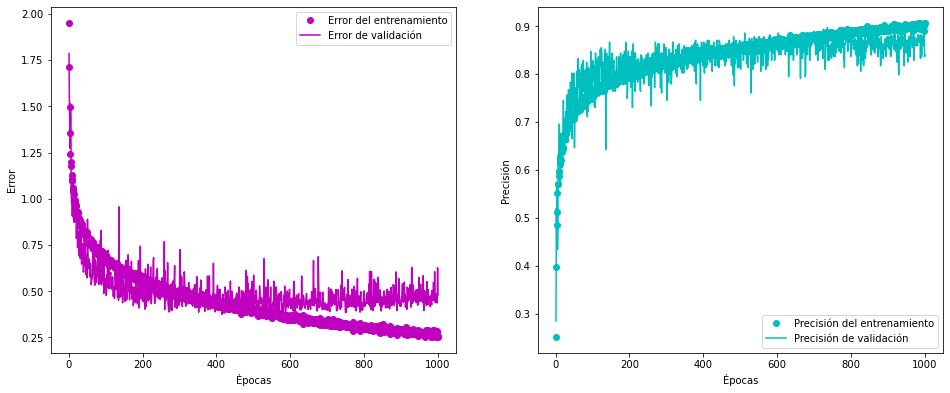

In [94]:
draw_history(history_4)

## Augmented set 2
Con la función *make_augmented_sets* se logró llegar a un mejor set de datos, con el que se logra casi un 90% de precisión.

In [10]:
cargado = np.load('train.npz')
tdata, tlabels = cargado.get("arr_0"), cargado.get("arr_1")

In [11]:
cargado = np.load('val.npz')
vdata, vlabels = cargado.get("arr_0"), cargado.get("arr_1")

In [81]:
model_4 = models.Sequential()
model_4.add(layers.Dense(64, activation="elu", input_shape=(136,)))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(64, activation="elu"))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(64, activation="elu"))
model_4.add(layers.Dropout(0.2))
model_4.add(layers.Dense(num_emotions, activation="softmax"))

In [82]:
model_4.compile(loss='categorical_crossentropy',#the quantity to minimize during training, 'categorical_crossentropy' measures the distance between two probability distributions
                optimizer='rmsprop', #specifies the exact way in which the gradient of the loss will to update parameters
                metrics=['accuracy'])

In [83]:
history_4 = model_4.fit(np.array(tdata),
                      np.array(tlabels),
                      epochs=200,
                      batch_size=512,
                      validation_data=(np.array(vdata), np.array(vlabels)))

Train on 10540 samples, validate on 264 samples
Epoch 1/200
10540/10540 [==============================] - 0s 37us/step - loss: 1.8760 - accuracy: 0.3088 - val_loss: 1.6509 - val_accuracy: 0.4735
Epoch 2/200
10540/10540 [==============================] - 0s 13us/step - loss: 1.6573 - accuracy: 0.4135 - val_loss: 1.4403 - val_accuracy: 0.5568
Epoch 3/200
10540/10540 [==============================] - 0s 16us/step - loss: 1.4562 - accuracy: 0.4907 - val_loss: 1.2590 - val_accuracy: 0.5720
Epoch 4/200
10540/10540 [==============================] - 0s 15us/step - loss: 1.3384 - accuracy: 0.5196 - val_loss: 1.2149 - val_accuracy: 0.5606
Epoch 5/200
10540/10540 [==============================] - 0s 13us/step - loss: 1.2507 - accuracy: 0.5430 - val_loss: 1.2463 - val_accuracy: 0.5227
Epoch 6/200
10540/10540 [==============================] - 0s 13us/step - loss: 1.2070 - accuracy: 0.5568 - val_loss: 1.1147 - val_accuracy: 0.5833
Epoch 7/200
10540/10540 [==============================] - 0s 15

Epoch 56/200
10540/10540 [==============================] - 0s 13us/step - loss: 0.7527 - accuracy: 0.7293 - val_loss: 0.8977 - val_accuracy: 0.6515
Epoch 57/200
10540/10540 [==============================] - 0s 15us/step - loss: 0.7537 - accuracy: 0.7299 - val_loss: 0.7650 - val_accuracy: 0.7159
Epoch 58/200
10540/10540 [==============================] - 0s 13us/step - loss: 0.7666 - accuracy: 0.7241 - val_loss: 0.7172 - val_accuracy: 0.7348
Epoch 59/200
10540/10540 [==============================] - 0s 12us/step - loss: 0.7407 - accuracy: 0.7364 - val_loss: 0.7681 - val_accuracy: 0.7424
Epoch 60/200
10540/10540 [==============================] - 0s 13us/step - loss: 0.7691 - accuracy: 0.7231 - val_loss: 0.6786 - val_accuracy: 0.7652
Epoch 61/200
10540/10540 [==============================] - 0s 13us/step - loss: 0.7458 - accuracy: 0.7322 - val_loss: 0.6836 - val_accuracy: 0.7727
Epoch 62/200
10540/10540 [==============================] - 0s 15us/step - loss: 0.7450 - accuracy: 0.7355

Epoch 111/200
10540/10540 [==============================] - 0s 13us/step - loss: 0.6432 - accuracy: 0.7648 - val_loss: 0.6145 - val_accuracy: 0.7879
Epoch 112/200
10540/10540 [==============================] - 0s 13us/step - loss: 0.6458 - accuracy: 0.7666 - val_loss: 0.6137 - val_accuracy: 0.7765
Epoch 113/200
10540/10540 [==============================] - 0s 12us/step - loss: 0.6517 - accuracy: 0.7630 - val_loss: 0.5966 - val_accuracy: 0.8144
Epoch 114/200
10540/10540 [==============================] - 0s 13us/step - loss: 0.6507 - accuracy: 0.7670 - val_loss: 0.6070 - val_accuracy: 0.8106
Epoch 115/200
10540/10540 [==============================] - 0s 15us/step - loss: 0.6541 - accuracy: 0.7691 - val_loss: 0.6920 - val_accuracy: 0.7803
Epoch 116/200
10540/10540 [==============================] - 0s 16us/step - loss: 0.6396 - accuracy: 0.7733 - val_loss: 0.6309 - val_accuracy: 0.7917
Epoch 117/200
10540/10540 [==============================] - 0s 15us/step - loss: 0.6487 - accuracy:

10540/10540 [==============================] - 0s 13us/step - loss: 0.5900 - accuracy: 0.7891 - val_loss: 0.5849 - val_accuracy: 0.7992
Epoch 166/200
10540/10540 [==============================] - 0s 13us/step - loss: 0.5938 - accuracy: 0.7878 - val_loss: 0.6227 - val_accuracy: 0.8182
Epoch 167/200
10540/10540 [==============================] - 0s 12us/step - loss: 0.5766 - accuracy: 0.7879 - val_loss: 0.6360 - val_accuracy: 0.7841
Epoch 168/200
10540/10540 [==============================] - 0s 12us/step - loss: 0.5927 - accuracy: 0.7834 - val_loss: 0.6083 - val_accuracy: 0.7955
Epoch 169/200
10540/10540 [==============================] - 0s 12us/step - loss: 0.5917 - accuracy: 0.7833 - val_loss: 0.6741 - val_accuracy: 0.7879
Epoch 170/200
10540/10540 [==============================] - 0s 13us/step - loss: 0.5889 - accuracy: 0.7877 - val_loss: 0.5205 - val_accuracy: 0.8333
Epoch 171/200
10540/10540 [==============================] - 0s 12us/step - loss: 0.5758 - accuracy: 0.7880 - val_

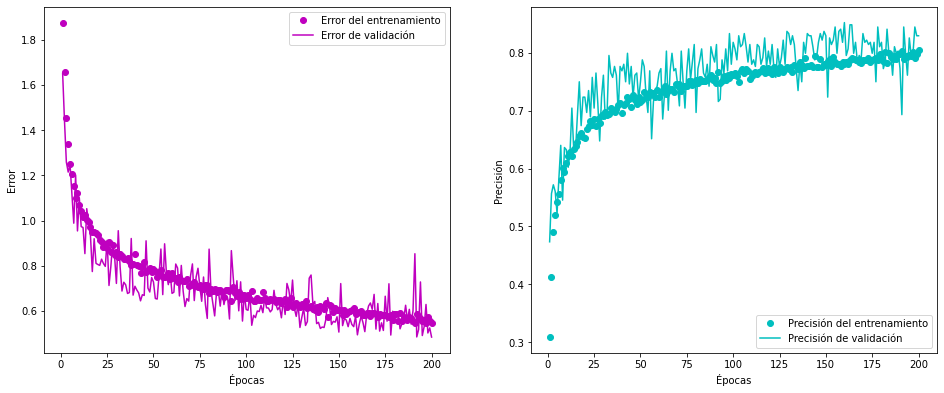

In [84]:
draw_history(history_4)

In [85]:
model_4.save('model_4_augmented.5')

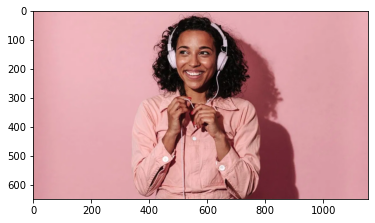

0.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
100.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [86]:
predictEmotion('test.jpg','model_4_augmented.h5')

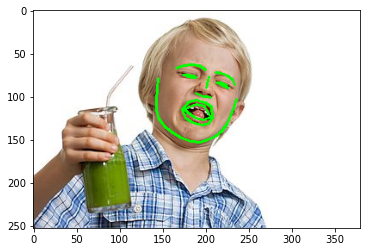

100.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [114]:
predictEmotion('test3.jpg','model_4_augmented.h5') #disgust--> cambiar!!

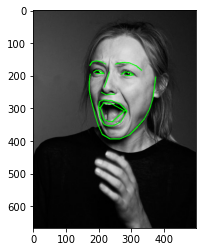

0.0% of anger
0.0% of contempt
0.0% of disgust
100.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [113]:
predictEmotion('test4.jpg', 'model_4_augmented.h5')

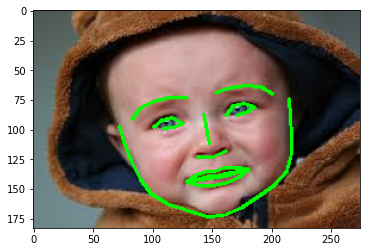

0.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
1.0% of neutral
99.0% of sadness
0.0% of surprise


In [112]:
predictEmotion('test5.jpg', 'model_4_augmented.h5')

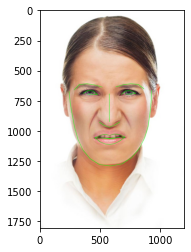

0.0% of anger
0.0% of contempt
100.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [111]:
predictEmotion('test6.jpg', 'model_4_augmented.h5')

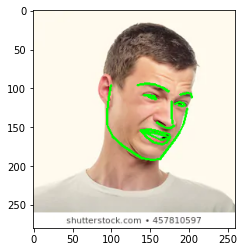

0.0% of anger
0.0% of contempt
100.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [110]:
predictEmotion('test7.jpg', 'model_4_augmented.h5')

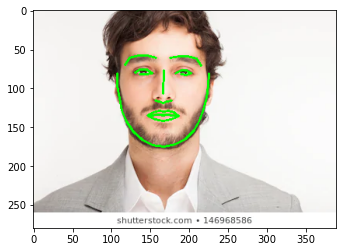

0.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
100.0% of neutral
0.0% of sadness
0.0% of surprise


In [109]:
predictEmotion('test8.jpg', 'model_4_augmented.h5')

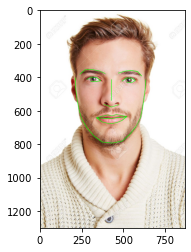

0.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
2.0% of neutral
98.0% of sadness
0.0% of surprise


In [108]:
predictEmotion('test9.jpg', 'model_4_augmented.h5')#neutral--> cambiar!!

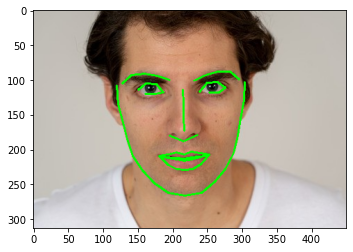

0.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
100.0% of neutral
0.0% of sadness
0.0% of surprise


In [106]:
predictEmotion('test10.jpg', 'model_4_augmented.h5')

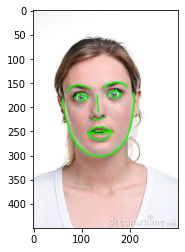

0.0% of anger
0.0% of contempt
0.0% of disgust
95.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
5.0% of surprise


In [107]:
predictEmotion('test11.jpg', 'model_4_augmented.h5') #surprise--> cambiar!!

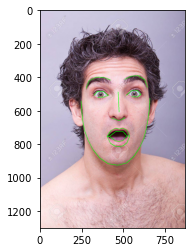

0.0% of anger
0.0% of contempt
0.0% of disgust
100.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [103]:
predictEmotion('test12.jpg', 'model_4_augmented.h5')#surprise--> cambiar!!

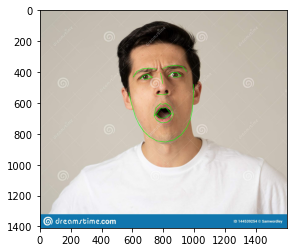

2.0% of anger
0.0% of contempt
0.0% of disgust
98.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [104]:
predictEmotion('test13.jpg', 'model_4_augmented.h5') #surprise--> cambiar!!

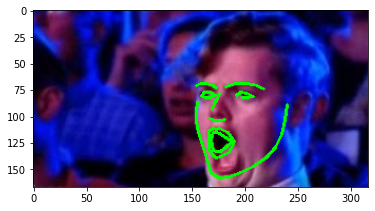

99.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
1.0% of surprise


In [101]:
predictEmotion('test14.jpg', 'model_4_augmented.h5') #suprise --> cambiar!!

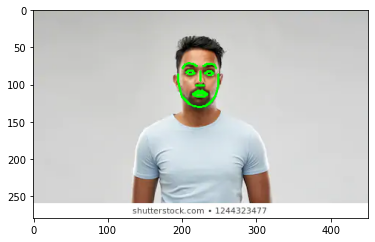

0.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
100.0% of sadness
0.0% of surprise


In [121]:
predictEmotion('test15.jpg', 'model_4_augmented.h5')

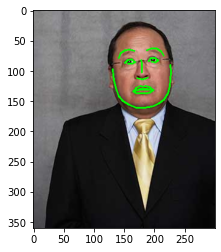

0.0% of anger
0.0% of contempt
0.0% of disgust
100.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [118]:
predictEmotion('test16.jpg', 'model_4_augmented.h5')

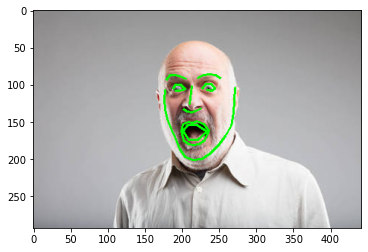

0.0% of anger
0.0% of contempt
0.0% of disgust
100.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [119]:
predictEmotion('test17.jpg', 'model_4_augmented.h5')

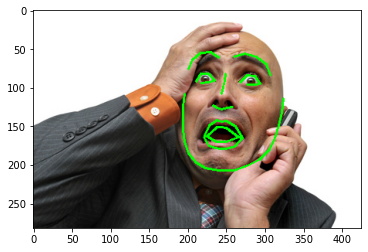

0.0% of anger
0.0% of contempt
0.0% of disgust
100.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [120]:
predictEmotion('test18.jpg', 'model_4_augmented.h5')

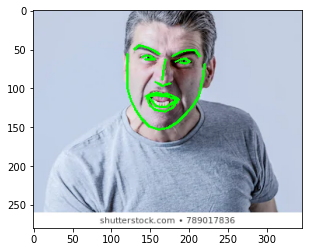

100.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [122]:
predictEmotion('test19.jpg', 'model_4_augmented.h5')

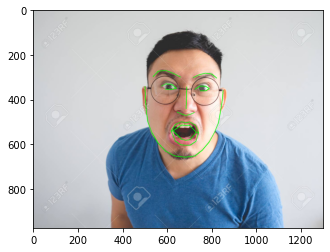

3.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
97.0% of surprise


In [124]:
predictEmotion('test20.jpg', 'model_4_augmented.h5') #enojo --> cambiar!

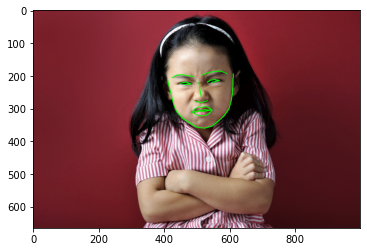

0.0% of anger
0.0% of contempt
100.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [126]:
predictEmotion('test21.jpg', 'model_4_augmented.h5') #estaria enojada --> cambiar

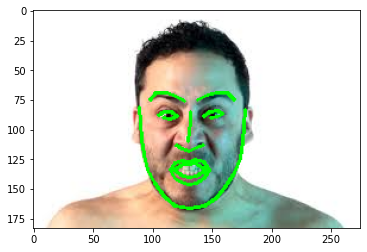

100.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [127]:
predictEmotion('test22.jpg', 'model_4_augmented.h5')

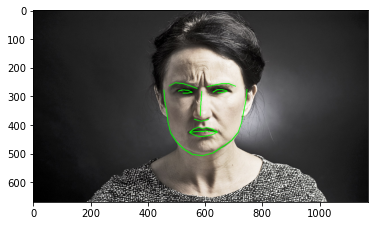

100.0% of anger
0.0% of contempt
0.0% of disgust
0.0% of fear
0.0% of happiness
0.0% of neutral
0.0% of sadness
0.0% of surprise


In [128]:
predictEmotion('test23.jpg', 'model_4_augmented.h5')